# Time series plot of COVID-19 cummulative confirmed cases by country

Hiroshi Maruyama (Twitter: @maruyama)

## Log plot of confirmes cases

Data source: Johns Hopkins University Center for Systems Science and Engineering ([GitHub](https://github.com/CSSEGISandData/COVID-19), [Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6))


last_date = 3/27/20


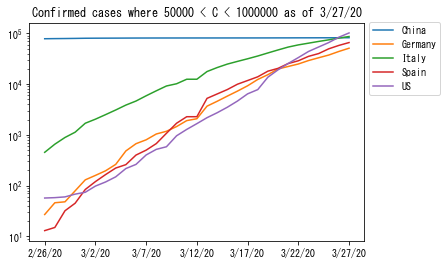

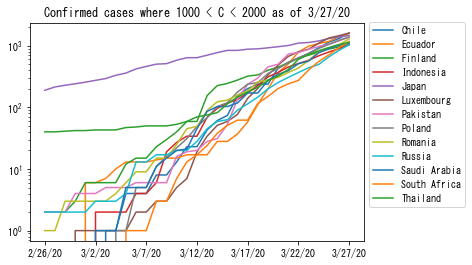

In [22]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = df.drop(columns=["Lat", "Long"])

last_date = df.columns[-1]
print("last_date =", last_date)

country_df = df.groupby("Country/Region").sum()

def plot_log_confirmed(min, max):
    t = country_df[(min <= country_df[last_date]) & (country_df[last_date] < max)  ].T
    title = "Confirmed cases where {} < C < {} as of {}".format(min, max, last_date)
    t[35:].plot(logy=True, title=title).legend(bbox_to_anchor=(1, 1.03), loc='upper left')

plot_log_confirmed(50000, 1000000)
plot_log_confirmed(2000, 50000)
plot_log_confirmed(1000,  2000)
plot_log_confirmed(500,   1000)
plot_log_confirmed(300,    500)
plot_log_confirmed(200,    300)

## Daily increase rate of reported case by country

In [35]:
# 日次再生算数R（３日間の移動平均）をプロット
# Daily increase rate of reported case by country (moving average of windows size = 3)
countries = ("Japan", "France", "Germany", "Korea, South", "US", "United Kingdom", "Taiwan*")
# countries = ("Japan", "France", "Germany", "US", "Singapore", "United Kingdom", "Spain", "Switzerland")
window = 3
daily_r = country_df.T.pct_change() + 1.0
# daily_r.iloc[30:].loc[:, countries].rolling(window).mean().iloc[window:].plot(title="Daily Reproduction Rate by Country (Window size={})".format(window))

data_to_plot = np.exp(np.log(daily_r.iloc[30:].loc[:, countries]).rolling(window).mean().iloc[window:])
title = "Daily Increase Rate of Reported Case as of {} (Window size={})".format(last_date, window)
data_to_plot.plot(title=title, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
# data_to_plot

## (Deprecated) Japanese daily increase rate of reported case by prefecture

Data source: Toyo Keizai Online

Thanks to [Kazuki Ogiwara](https://toyokeizai.net/list/author/%E8%8D%BB%E5%8E%9F+%E5%92%8C%E6%A8%B9) of Toyo Keizai Online ([GitHub](https://github.com/kaz-ogiwara/covid19/), [Dashboard](https://toyokeizai.net/sp/visual/tko/covid19/))

len= 1036


<Figure size 432x288 with 0 Axes>

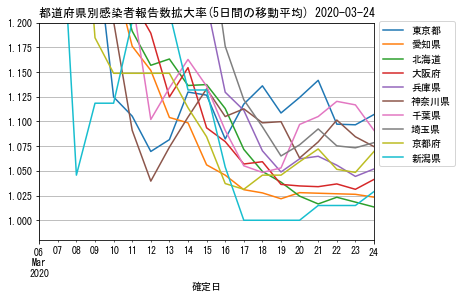

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'MS Gothic'}
mpl.rc('font', **font)


df = pd.read_csv('https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/individuals.csv', 
                 parse_dates=[["確定年", "確定月", "確定日"]])
print("len=", len(df))
# display(df)
# print(df.columns)
df = df.drop(['新No.', '旧No.', '年代', '性別', '居住地2', '備考'], axis=1)

# df.groupby("居住地").count()
#df.groupby(["確定年", "確定月", "確定日"]).count()
def get_data_by_pref(pref):  # 県ごとのデータを取得
    ts = df[df["居住地1"] == pref].groupby("確定年_確定月_確定日").count()
    ts.reset_index(inplace = True)
    # ts = ts.rename(columns={'確定年_確定月_確定日': '確定日',"居住地":"愛知県" })
    ts = ts.rename(columns={'確定年_確定月_確定日': '確定日',"居住地1" : pref})
    # ts = ts.set_index("確定日")
    return ts

fig = plt.figure()
window = 5
pref_data = get_data_by_pref("東京都")

for pref in ("愛知県", "北海道", "大阪府", "兵庫県", "神奈川県","千葉県","埼玉県","京都府","新潟県"):
    pref_data = pref_data.merge(get_data_by_pref(pref), how='outer', sort=True)
    # print(pref_data.describe())
# get_data_by_pref("東京都")
pref_data = pref_data.set_index("確定日")
last_date = pref_data.index[-1].date()

title = "都道府県別感染者報告数拡大率({}日間の移動平均) {}".format(window, last_date)

data_to_plot = np.exp(np.log(pref_data.loc["2020-03-1":,:].fillna(0).cumsum().pct_change() + 1.0).rolling(window).mean()).iloc[window:, :]
data_to_plot.plot(title=title, ylim=[0.98, 1.2], grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
# data_to_plot


# Japanese daily increase rate by prefecture

Data source: [Jag Japan](https://gis.jag-japan.com/covid19jp/)

In [34]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'MS Gothic'}
mpl.rc('font', **font)
fn = 'https://dl.dropboxusercontent.com/s/6mztoeb6xf78g5w/COVID-19.csv'
fn = 'data/JAG_Japan/COVID-19.csv'

def read_data():
    d = pd.read_csv(fn,usecols=["確定日", "受診都道府県"],parse_dates=["確定日"])
    d = d.drop(["不明", "中部国際空港", "成田空港", "羽田空港", "関西国際空港"], errors='ignore')
    return d

def get_data_by_pref(df, pref):  # 県ごとのデータを取得
    ts = df[df["受診都道府県"] == pref].groupby("確定日").count()
    ts.reset_index(inplace = True)
    # ts = ts.rename(columns={'確定年_確定月_確定日': '確定日',"居住地":"愛知県" })
    ts = ts.rename(columns={"受診都道府県" : pref})
    # ts = ts.set_index("確定日")
    return ts

df = read_data()
fig = plt.figure()
window = 5
pref_data = get_data_by_pref(df, "東京都")


for pref in ("愛知県", "北海道", "大阪府", "兵庫県", "神奈川県","千葉県","埼玉県","京都府","新潟県"):
    d = get_data_by_pref(df, pref)
    # display(d)
    pref_data = pref_data.merge(d, how='outer', sort=True)
    # print(pref_data.describe())  

pref_data = pref_data.set_index("確定日")
last_date = pref_data.index[-1].date()

# display(pref_data)

title = "都道府県別感染者報告数拡大率({}日間の移動平均) {}".format(window, last_date)

data_to_plot = np.exp(np.log(pref_data.loc["2020-03-1":,:].fillna(0).cumsum().pct_change() + 1.0).rolling(window).mean()).iloc[window:, :]
data_to_plot.plot(title=title, ylim=[0.98, 1.3], grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
data_to_plot

東京都       愛知県       北海道       大阪府       兵庫県      神奈川県  \
確定日                                                                      
2020-03-06  1.600434  1.615394  1.502870       NaN  1.515717  1.534206   
2020-03-07  1.682933  1.678757  1.328801  1.792398  1.584893  1.207911   
2020-03-08  1.551846  1.335604  1.312094  1.663804  1.319508  1.176079   
2020-03-09  1.309945  1.233017  1.264332  1.314393  1.397654  1.176079   
2020-03-10  1.148698  1.201124  1.260927  1.375765  1.442700  1.107566   
2020-03-11  1.113824  1.178445  1.211392  1.229957  1.365648  1.080185   
2020-03-12  1.070740  1.154385  1.164123  1.180982  1.356912  1.076317   
2020-03-13  1.081781  1.107566  1.155189  1.115276  1.360822  1.084472   
2020-03-14  1.131153  1.100481  1.125934  1.139544  1.331653  1.092388   
2020-03-15  1.120549  1.056180  1.094218  1.081310  1.258744  1.098561   
2020-03-16  1.080425  1.046197  1.064468  1.064741  1.171923  1.069610   
2020-03-17  1.113335  1.032028  1.057510  1.049062  1.133308  1.073114   
2020-03-18  1.130926  1.035096  1.033754  1.051282  1.101972  1.087136   
2020-03-19  1.101293  1.026787  1.029755  1.032510  1.072333  1.104384   
2020-03-20  1.116612  1.036385  1.019245  1.031310  1.050362  1.088953   
2020-03-21  1.133109  1.035662  1.021046  1.030743  1.049593  1.082398   
2020-03-22  1.092148  1.034968  1.023281  1.032942  1.056127  1.078545   
2020-03-23  1.095950  1.028081  1.018152  1.028426  1.047928  1.056628   
2020-03-24  1.105921  1.025349  1.017555  1.037137  1.046079  1.061517   
2020-03-25  1.137235  1.025896  1.019666  1.040313  1.033344  1.061377   
2020-03-26  1.175286  1.027066  1.014932  1.046674  1.023198  1.070197   
2020-03-27  1.210030  1.028190  1.020851  1.062539  1.017104  1.084472   
2020-03-28  1.226703  1.024620  1.018646  1.075424  1.018438  1.112446   

                 千葉県       埼玉県       京都府       新潟県  
確定日                                                 
2020-03-06  1.475773       NaN       NaN       NaN  
2020-03-07  1.515717       NaN       NaN  1.045640  
2020-03-08  1.350960       NaN  1.430969  1.045640  
2020-03-09  1.350960       NaN  1.272260  1.118427  
2020-03-10  1.319508  1.406282  1.224240  1.148698  
2020-03-11  1.148698  1.210583  1.210583  1.148698  
2020-03-12  1.148698  1.306041  1.201124  1.210583  
2020-03-13  1.161187  1.340801  1.201124  1.210583  
2020-03-14  1.161187  1.360822  1.084472  1.164659  
2020-03-15  1.096262  1.205461  1.063995  1.084472  
2020-03-16  1.062980  1.165851  1.029034  1.124746  
2020-03-17  1.055893  1.116740  1.025349  1.089977  
2020-03-18  1.038950  1.055118  1.048413  1.100665  
2020-03-19  1.088251  1.062980  1.048413  1.089249  
2020-03-20  1.095654  1.079258  1.059224  1.098561  
2020-03-21  1.095654  1.113824  1.069610  1.076317  
2020-03-22  1.107566  1.086654  1.052918  1.053874  
2020-03-23  1.093742  1.084472  1.038950  1.043640  
2020-03-24  1.071710  1.088251  1.056422  1.032588  
2020-03-25  1.084472  1.075508  1.077144  1.031310  
2020-03-26  1.111962  1.081442  1.087893  1.014932  
2020-03-27  1.098561  1.090195  1.084472  1.022080  
2020-03-28  1.257058  1.102305  1.105633  1.029034

<Figure size 432x288 with 0 Axes>

## Projection of confirmed cases by different reproduction rates


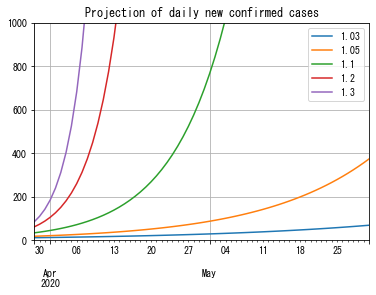

In [38]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

start_date = "2020/03/29"
end_date = "2020/05/31"
I0 = 362
reproduction_rates = np.array([1.03, 1.05, 1.1, 1.2, 1.3])

dates = pd.date_range(start_date, end_date)
c = np.zeros((len(dates), len(reproduction_rates)))
for i in range(len(reproduction_rates)):
    c[:,i] = reproduction_rates[i] ** (np.arange(len(dates)) - 1) * I0 * (reproduction_rates[i] - 1)


sim = pd.DataFrame(c, index=dates, columns=reproduction_rates)
sim.plot(ylim=[0, 1000], title="Projection of daily new confirmed cases", grid=True)


In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-21-2020.csv')
df = df.drop(columns=["Latitude", "Longitude"])
country_df = df.groupby("Country/Region").sum()
country_df = country_df[(country_df["Confirmed"] > 500) & (country_df["Confirmed"] < 2000) ]

# 散布図を描画
a = country_df.plot.scatter(x='Confirmed', y='Deaths', alpha=0.5)
# 各要素にラベルを表示
for k, v in country_df.iterrows():
    # print(k, v)
    a.annotate(k, xy=(v[0],v[1]), size=15)

country_df

Confirmed  Deaths  Recovered
Country/Region                              
Australia            1071       7         26
Brazil               1021      15          2
Canada               1278      19         10
Chile                 537       0          6
Cruise Ship           712       8        325
Czechia               995       0          6
Denmark              1420      13          1
Ecuador               506       7          3
Finland               523       1         10
Greece                530      13         19
Ireland               785       3          5
Israel                883       1         36
Japan                1007      35        232
Luxembourg            670       8          0
Malaysia             1183       4        114
Pakistan              730       3         13
Poland                536       5          1
Portugal             1280      12          5
Sweden               1763      20         16
Turkey                670       9          0